In [6]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torchinterp1d import interp1d


In [21]:
def generate_wavelength_grid():
    grid = [
        (15050, 15850, 0.2),
        (15870, 16440, 0.2),
        (16475, 17100, 0.2),
        (4700, 4930, 0.05),
        (5630, 5880, 0.05),
        (6420, 6800, 0.05),
        (7500, 7920, 0.05)
    ]

    wavelength_grid = []
    for start, end, step in grid:
        wavelength_grid.extend(np.arange(start, end + step, step))
    
    return np.array(wavelength_grid)


high_res_wavelength = generate_wavelength_grid()
high_res_flux = np.random.uniform(0.5, 1.5, len(high_res_wavelength))  # Random flux values

# Ensure the high-resolution wavelength grid is sorted
high_res_wavelength = np.sort(high_res_wavelength)
high_res_flux = high_res_flux[np.argsort(high_res_wavelength)]

# Convert high-resolution wavelength and flux to torch tensors
high_res_wavelength = torch.FloatTensor(high_res_wavelength)
high_res_flux = torch.FloatTensor(high_res_flux)




In [22]:
# Step 2: Read Observed Data from HDF5 File
hdf5_path = 'data/healpixfiles_inter/spectra_healpix_170.hdf5'  

with h5py.File(hdf5_path, 'r') as f:
    group = f['170_combined_11']
    observed_wavelength = torch.FloatTensor(group['wavelength'][:])
    observed_flux = torch.FloatTensor(group['flux'][:])

# Step 3: Perform Interpolation
interpolated_flux = interp1d(high_res_wavelength.unsqueeze(0), high_res_flux.unsqueeze(0), observed_wavelength.unsqueeze(0))
interpolated_flux = interpolated_flux.squeeze()


In [29]:
# Step 3: Extend the Observed Wavelength Grid with Padding
padding = 5  # Number of extra points to add before and after each channel
extended_wavelengths = []

channels = [
    (4711, 4906, 0.05),
    (5647, 5875, 0.05),
    (6475, 6737, 0.05),
    (7583, 7885, 0.05),
    (15100, 17000, 0.2)
]

for start, end, step in channels:
    pre_pad = np.arange(start - padding * step, start, step)
    post_pad = np.arange(end + step, end + (padding + 1) * step, step)
    channel = np.arange(start, end + step, step)
    extended_wavelengths.extend(pre_pad)
    extended_wavelengths.extend(channel)
    extended_wavelengths.extend(post_pad)

extended_wavelengths = np.unique(np.array(extended_wavelengths))
extended_wavelengths = torch.FloatTensor(extended_wavelengths)

In [31]:
# Step 4: Perform Interpolation
interpolated_flux = interp1d(high_res_wavelength.unsqueeze(0), high_res_flux.unsqueeze(0), extended_wavelengths.unsqueeze(0))
interpolated_flux = interpolated_flux.squeeze()

# Extract the relevant interpolated values for the original observed wavelength grid
generated_interpolated_flux = interp1d(high_res_wavelength.unsqueeze(0), high_res_flux.unsqueeze(0), observed_wavelength.unsqueeze(0))
generated_interpolated_flux = generated_interpolated_flux.squeeze()


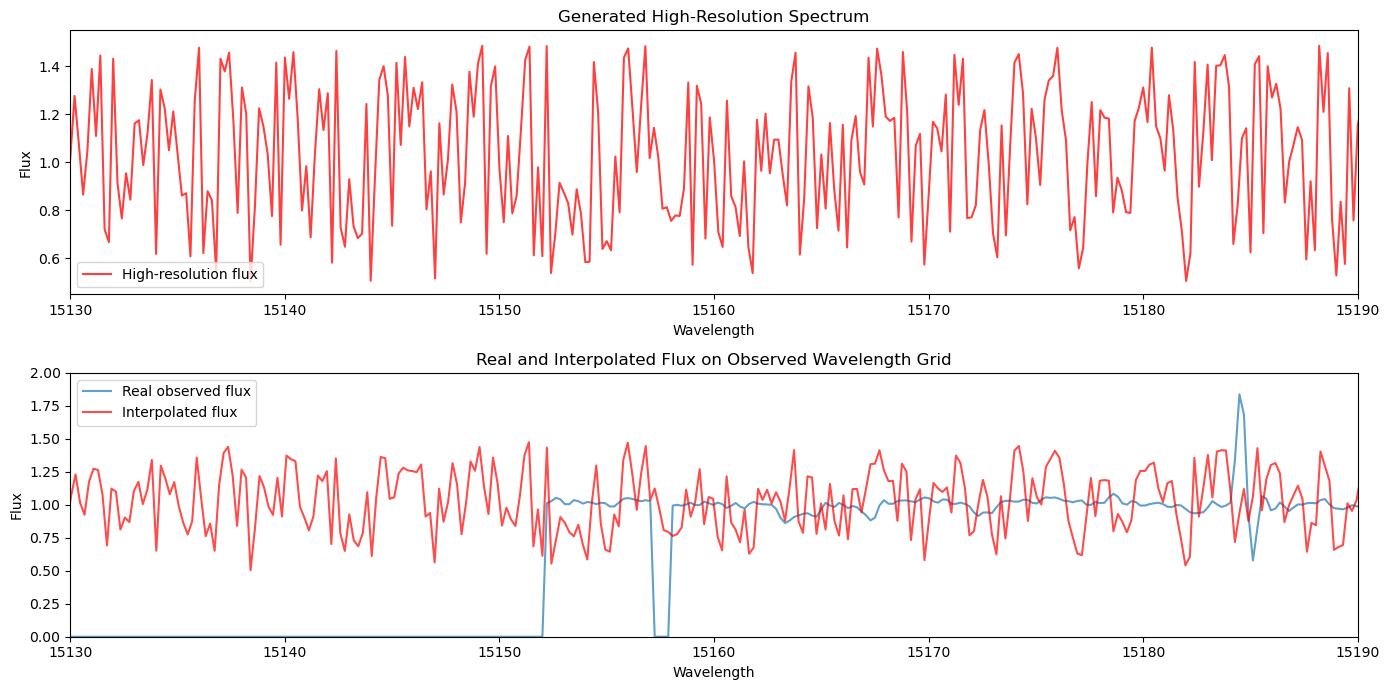

In [38]:
# Plotting
plt.figure(figsize=(14, 7))

# Subplot 1: Generated High-Resolution Spectrum
plt.subplot(2, 1, 1)
plt.plot(high_res_wavelength.numpy(), high_res_flux.numpy(), label='High-resolution flux', alpha=0.75, color='red')
plt.xlim(15130, 15190)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Generated High-Resolution Spectrum')
plt.legend()

# Subplot 2: Real Flux and Interpolated Flux on Observed Wavelength Grid
plt.subplot(2, 1, 2)
plt.plot(observed_wavelength.numpy(), observed_flux.numpy(), label='Real observed flux', alpha=0.7)
plt.plot(observed_wavelength.numpy(), generated_interpolated_flux.numpy(), label='Interpolated flux',color='red',  alpha=0.7)
plt.xlabel('Wavelength')
plt.xlim(15130, 15190)
plt.ylim (0,2)
plt.ylabel('Flux')
plt.title('Real and Interpolated Flux on Observed Wavelength Grid')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Step 5: Print values between 15170 and 15180
wavelength_range = (observed_wavelength >= 15170) & (observed_wavelength <= 15173)
selected_wavelengths = observed_wavelength[wavelength_range]
selected_observed_flux = observed_flux[wavelength_range]
selected_interpolated_flux = generated_interpolated_flux[wavelength_range]

In [42]:
selected_observed_flux

tensor([1.0494, 1.0263, 1.0162, 1.0395, 1.0391, 1.0072, 1.0072, 1.0156, 1.0070,
        0.9884, 0.9422, 0.9150, 0.9408, 0.9423, 0.9359])

In [43]:
selected_interpolated_flux

tensor([0.8828, 1.1654, 1.1252, 1.0975, 1.1315, 0.9409, 1.3727, 1.3174, 1.1269,
        0.7690, 0.7986, 1.0091, 1.1886, 1.0617, 0.7774])